<a href="https://colab.research.google.com/github/pachterlab/FGP_2023/blob/main/moments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import construct_H
import simulation
import noise
import importlib
importlib.reload(simulation)

ModuleNotFoundError: ignored

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
from google.colab import drive
import os
import importlib.util

# Mount Google Drive
drive.mount('/content/drive')

# Path to the directory containing your .py files
directory_path = '/content/drive/MyDrive/Colab Notebooks/FGP_2023/'

# Get a list of .py files in the directory
py_files = [file for file in os.listdir(directory_path) if file.endswith('.py')]

# Import each .py file as a module
for py_file in py_files:
    module_name = os.path.splitext(py_file)[0]  # Module name without extension
    module_path = os.path.join(directory_path, py_file)  # Full path to the module

    spec = importlib.util.spec_from_file_location(module_name, module_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)

    # Now you can use functions/classes from the imported module
    # For example:
    # module.some_function()
    print(f"Imported module: {module_name}")

from FGP_2023.construct_H import basis_sort, create_binaries, construct_H
from FGP_2023.simulation import create_samples, analytic_ss
from FGP_2023.noise import get_combos


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imported module: construct_H
Imported module: noise
Imported module: simulation
Package FGP_2023 is being imported!
Imported module: __init__


In [ ]:
def get_moments(samples, sites, n):
    '''

    Args:
        samples (array): Simulated data with cells in form [[N-dim state vector], [n-dim transcript vector]]
        sites (tuple of integers): zero-indexed sites for which correlations will be calculated.
        n (int): number of sites.

    Output:
        dictionary with means, variances, covariances, correlations for site openness and transcript numbers.
    '''

    N = 2**n
    site1, site2 = sites

    # Take only the gene-state information from the simulated cells.
    state_info = samples[:, :N]
    # Move from categorical vector form to gene state indices. (e.g. [0,0,1,0] --> 3)
    state_indices = [list(state).index(1) for state in state_info]
    # Move from gene-state index to openness value at each site.
    combos = get_combos(n)
    site_values = [combos[i] for i in state_indices]

    # Extract site openness at each site for each cell.
    sites1 = [configuration[site1] for configuration in site_values]
    sites2 = [configuration[site2] for configuration in site_values]

    # Calculate site-openness moments.
    site_mean_1, site_mean_2 = np.mean(sites1), np.mean(sites2)
    site_var_1, site_var_2 = np.var(sites1), np.var(sites2)
    site_covar = np.cov(sites1, sites2)[0][1]
    site_corr = site_covar/(site_var_1*site_var_2)**(1/2)

    # Extract only the transcript copy number information from the simulated cells.
    transcripts1, transcripts2 = samples[:, N + site1], samples[:, N + site2]

    # Calculate transcript copy number moments.
    transcript_mean_1, transcript_mean_2 = np.mean(transcripts1), np.mean(transcripts2)
    transcript_var_1, transcript_var_2 = np.var(transcripts1), np.var(transcripts2)

    transcript_covar = np.cov(transcripts1, transcripts2)[0][1]
    transcript_corr = transcript_covar / (transcript_var_1 * transcript_var_2)**(1/2)

    # Calculate ratio of correlations.
    f = transcript_corr/site_corr

    sim_moments = {
    'site_mean_1': site_mean_1,
    'site_mean_2': site_mean_2,
    'site_var_1': site_var_1,
    'site_var_2': site_var_2,
    'site_covar': site_covar,
    'site_corr': site_corr,
    'transcript_mean_1': transcript_mean_1,
    'transcript_mean_2': transcript_mean_2,
    'transcript_var_1': transcript_var_1,
    'transcript_var_2': transcript_var_2,
    'transcript_covar': transcript_covar,
    'transcript_corr': transcript_corr,
        'f':f
    }

    return sim_moments

In [ ]:
def gene_state_matrix(n):
    '''
    Generate state matrix S.

    Args:
        n (int): Number of sites.

    Output:
        S (2**n x n matrix): S defined such that S[alpha][i] is the openness of site i in gene configuration alpha.
    '''

    combos = get_combos(n)
    S = np.array(combos)
    return S

In [ ]:
def calc_moments(k_ons, k_off, bs, ds, epsilon, sites):
    '''
    Calculate gene-state and transcript moments analytically for the Ising system.

    Args:
        k_ons (list of floats): Rates of gene turning on for each site.
        k_off (float): Rate of gene turning off for all sites.
        bs (list of floats): Rates of transcription for each gene.
        ds (list of floats): Rates of decay for each transcript species
        sites (tuple of integers): indices of the two sites whose correlations are desired.

    Output:
        Dictionary with gene-state and transcript means, variances, covariances, correlations,
        and the fraction f, of transcript correlation to site openness correlation.
    '''

    n = len(k_ons)
    N = 2**n
    site1, site2 = sites

    # Create gene_state matrix
    S = gene_state_matrix(n)
    # Get steady-state gene-state distribution.
    pi = np.array(analytic_ss(k_ons, k_off, epsilon))

    # Average site openess.
    sigma_av = np.dot(pi.T, S)
    site_mean_1, site_mean_2 = sigma_av

    # Average product of the two sites' opennesses.
    Pi_matrix = np.diag(pi)
    sigma_prod_av = np.dot(np.dot(S.T, Pi_matrix), S)

    # Site openness variances, covariances, correlations.
    site_var_1 = sigma_prod_av[site1][site1] - site_mean_1**2
    site_var_2 =  sigma_prod_av[site2][site2] - site_mean_2**2
    site_covar = sigma_prod_av[site1][site2] - site_mean_1*site_mean_2
    site_corr = site_covar/(site_var_1*site_var_2)**(1/2)

    # Construct Ising transition matrix.
    Ht = construct_H(k_ons, k_off, epsilon).T
    # Transcription rate information for the Ising system.
    B_matrix = S*bs
    B1 = np.diag(B_matrix[:, site1])
    B2 = np.diag(B_matrix[:, site2])
    # Decay rate information.
    d1, d2 = ds[site1], ds[site2]

    # Inverse matrices defined in supplement for ease of calculation.
    M1 = np.linalg.inv(d1*np.identity(N) - Ht)
    M2 = np.linalg.inv(d2*np.identity(N) - Ht)

    # Transcript means conditional on being in each DNA configuration (these are length-N vectors).
    mu_cond_1 = np.linalg.inv(np.dot(d1*np.identity(N) - Ht, Pi_matrix))
    mu_cond_1 = np.dot(np.dot(mu_cond_1, B1), np.array([pi]).T)

    mu_cond_2 = np.linalg.inv(np.dot(d2*np.identity(N) - Ht, Pi_matrix))
    mu_cond_2 = np.dot(np.dot(mu_cond_2, B2), np.array([pi]).T)

    # Calculate total means from conditional means.
    # (equivalent to np.dot(pi.T,mu_cond_1)).
    mu1_vec = np.dot(np.dot(M1, B1), np.array([pi]).T)
    mu2_vec = np.dot(np.dot(M2, B2), np.array([pi]).T)
    mu1, mu2 = np.sum(mu1_vec), np.sum(mu2_vec)

    # Inverse matrix as defined in supplement.
    M12 = np.linalg.inv((d1+d2)*np.identity(N) - Ht)
    # Calculate expected product of the two transcript numbers.
    mu_12_vec = np.dot(M12, (np.dot(np.dot(B1, Pi_matrix), mu_cond_2) + np.dot(np.dot(B2, Pi_matrix), mu_cond_1)))
    mu_12 = np.sum(mu_12_vec)

    # Transcript covariance.
    transcript_covar = mu_12 - mu1*mu2

    # Calculate transcript variances.
    M11 = np.linalg.inv(2*d1*np.identity(N) - Ht)
    M22 = np.linalg.inv(2*d2*np.identity(N) - Ht)

    mu_11_vec = np.dot(np.dot(np.dot(M11, 2*B1), Pi_matrix), mu_cond_1)
    mu_22_vec = np.dot(np.dot(np.dot(M22, 2*B2), Pi_matrix), mu_cond_2)

    transcript_var_1 = np.sum(mu_11_vec) + mu1 - mu1**2
    transcript_var_2 = np.sum(mu_22_vec) + mu2 - mu2**2

    # Transcript correlation.
    transcript_corr = transcript_covar/(transcript_var_1*transcript_var_2)**(1/2)
    # Ratio of correlations.
    f = transcript_corr/site_corr

    calc_moments = {
    'site_mean_1': site_mean_1,
    'site_mean_2': site_mean_2,
    'site_var_1': site_var_1,
    'site_var_2': site_var_2,
    'site_covar': site_covar,
    'site_corr': site_corr,
    'transcript_mean_1': mu1,
    'transcript_mean_2': mu2,
    'transcript_var_1': transcript_var_1,
    'transcript_var_2': transcript_var_2,
    'transcript_covar': transcript_covar,
    'transcript_corr': transcript_corr,
        'f':f
    }

    return calc_moments

Simulated Statistics: 
 {'site_mean_1': 0.2313, 'site_mean_2': 0.3273, 'site_var_1': 0.17780031, 'site_var_2': 0.22017470999999997, 'site_covar': 0.055101020102010116, 'site_corr': 0.27849003883663787, 'transcript_mean_1': 0.6451, 'transcript_mean_2': 1.2166, 'transcript_var_1': 0.9107459899999998, 'transcript_var_2': 1.6996844400000002, 'transcript_covar': 0.17578891889188947, 'transcript_corr': 0.14128911734999397, 'f': 0.5073399319423202}
Calculated Statistics: 
 {'site_mean_1': 0.22580645161290305, 'site_mean_2': 0.3225806451612902, 'site_var_1': 0.17481789802289271, 'site_var_2': 0.21852237252861598, 'site_covar': 0.056191467221644115, 'site_corr': 0.28749445424997305, 'transcript_mean_1': 0.6774193548387092, 'transcript_mean_2': 1.2903225806451608, 'transcript_var_1': 0.9325008671522714, 'transcript_var_2': 1.7587235518557063, 'transcript_covar': 0.17537287547693436, 'transcript_corr': 0.1369427393211541, 'f': 0.4763317597844305}


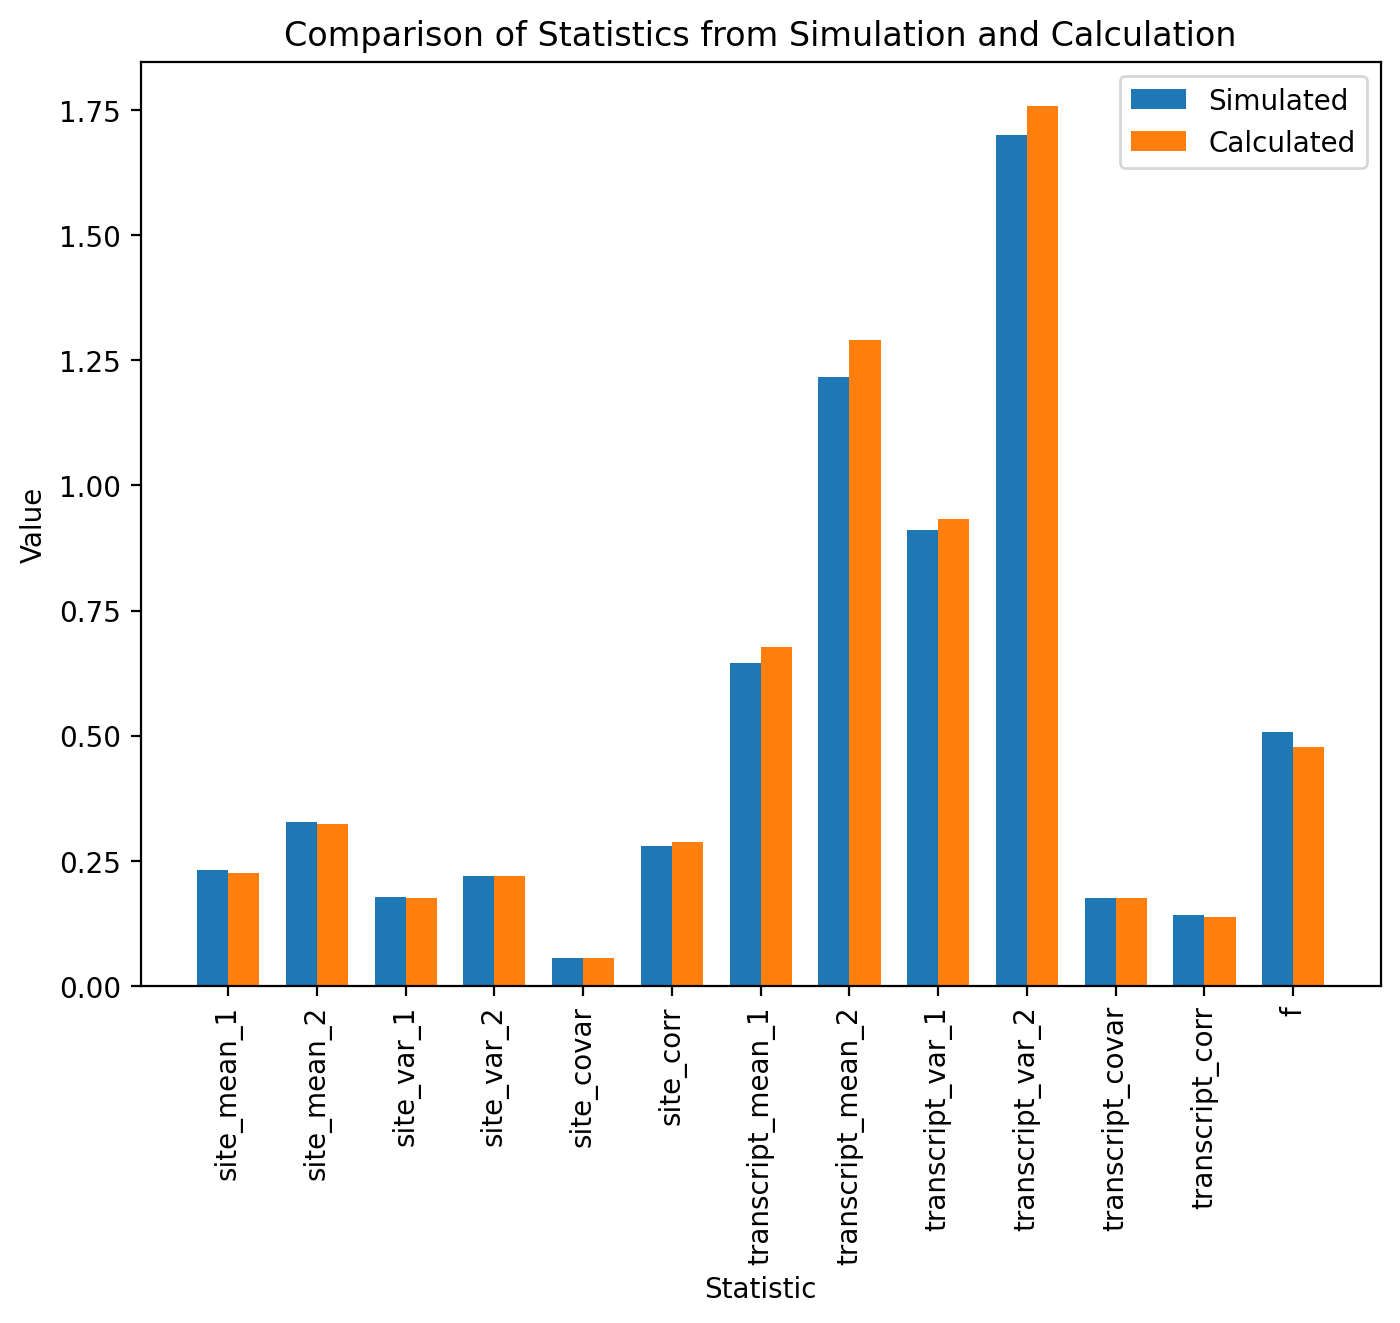

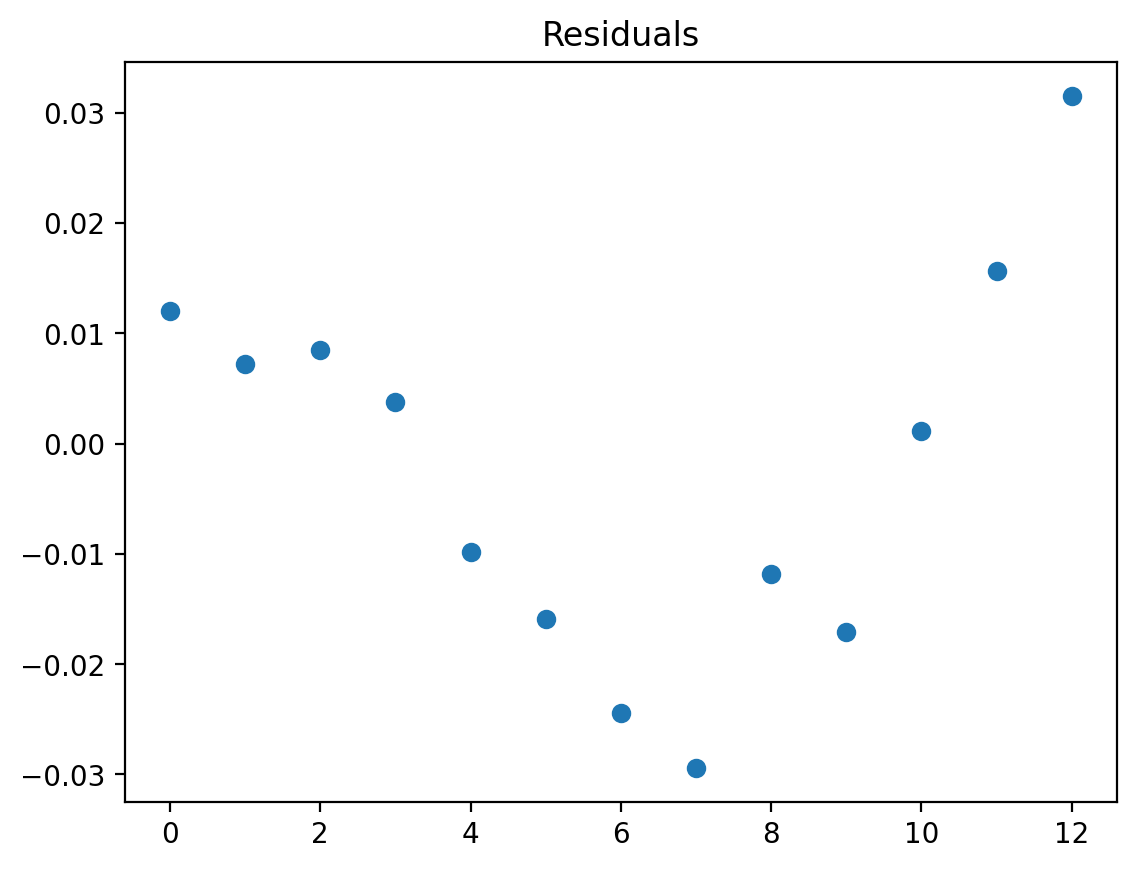

In [ ]:
## Simulate data without noise and calculate observered moments.

if __name__ == '__main__':

    # # Get large time steady state for Ising Markov chain:
    # k_ons, k_off, bs, ds, epsilon, nCells, sites, n = [1,2], 3, [3,4], [1,1], 0.5, 10000, (0,1), 2
    # # Choose an early time at which steady state has been reached since we use final slice.
    # simulation_time = 3/min(k_ons)
    # # Take last slice.
    # samples = create_samples(k_ons, k_off, bs, ds, epsilon, nCells, simulation_time)[1][:,-1,:]

    sim_moms = get_moments(samples, sites, 2)
    calc_moms = calc_moments(k_ons, k_off, bs, ds, epsilon, sites)

    print('Simulated Statistics: \n', sim_moms)
    print('Calculated Statistics: \n', calc_moms)

    # Plot bar chart comparing each statistic between the simulated and calculated.
    plt.figure(figsize=(8, 6))
    dict1, dict2 = sim_moms, calc_moms
    keys = list(dict1.keys())
    values_dict1 = [dict1[key] for key in keys]
    values_dict2 = [dict2[key] for key in keys]
    bar_width = 0.35
    index = range(len(keys))

    # Plotting
    plt.bar(index, values_dict1, bar_width, label='Simulated')
    plt.bar([i + bar_width for i in index], values_dict2, bar_width, label='Calculated')
    plt.xticks([i +bar_width / 2 for i in index], keys, rotation=90)  # Placing xticks at the center of the bars
    plt.xlabel('Statistic')
    plt.ylabel('Value')
    plt.title('Comparison of Statistics from Simulation and Calculation')
    plt.legend()
    plt.show()

    ## Plot residuals between simulated and calculated moments.
    x, y = sim_moms.values(), calc_moms.values()
    residuals = [(i-j)/(i+j) for i, j in zip(x,y)]
    plt.scatter([i for i in range(len(x))], residuals)
    plt.title('Residuals')
    plt.show()

In [ ]:
def contours_f(k_off, bs, ds, epsilon, sites):
    '''
    Create contour plots for the ratio of correlations, for a two-gene system, as in supplementary figure S3.
    '''
    size = 100
    levels = 15

    k_ons = np.linspace(0.5, int(k_off)+1, size)
    X, Y = np.meshgrid(k_ons, k_ons)

    fs = np.zeros((size,size))

    for i in range(size):
        for j in range(size):
            f = calc_moments([k_ons[i],k_ons[j]], k_off, bs, ds, epsilon, sites)['f']
            fs[i][j] = f

    plt.title('Correlation Fraction (f), epsilon='+str(epsilon))
    plt.xlabel('k-on 1')
    plt.ylabel('k-on 2')

    plt.contourf(X,Y,fs,levels)
    plt.colorbar()
    plt.show()

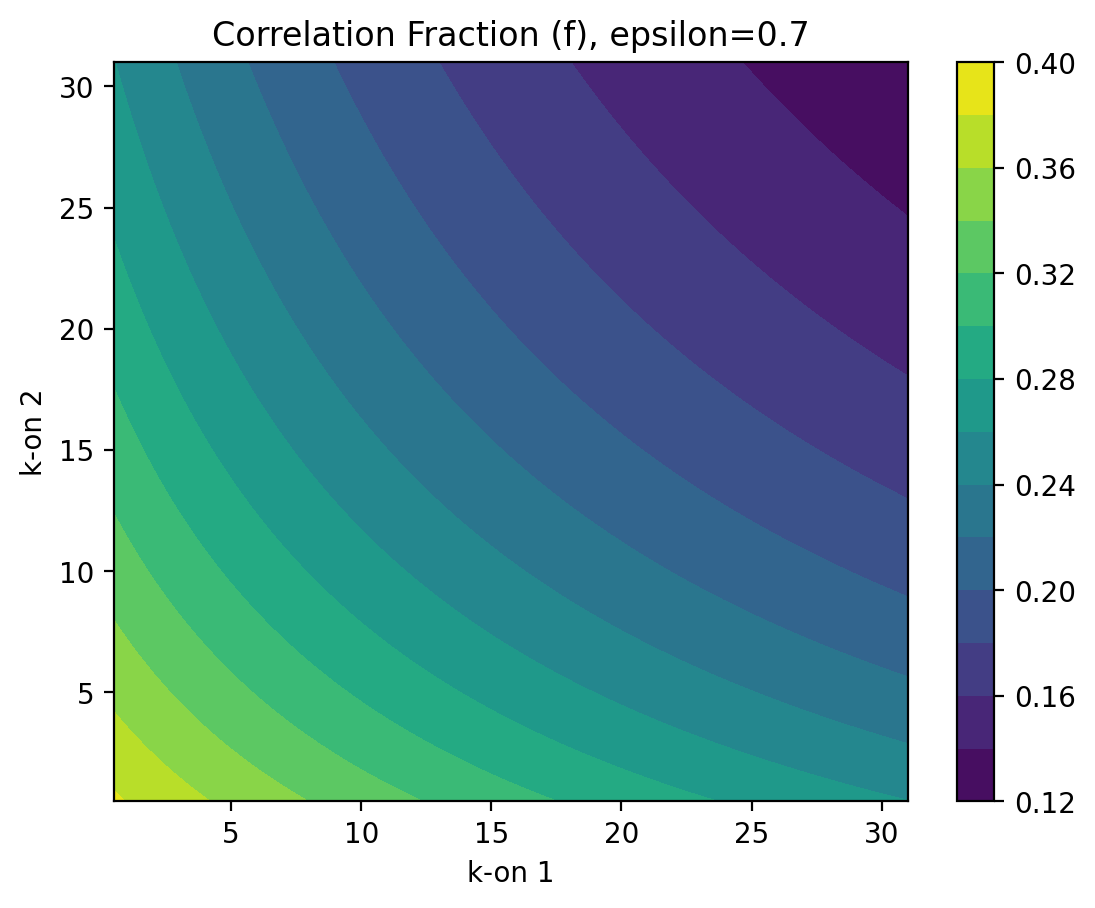

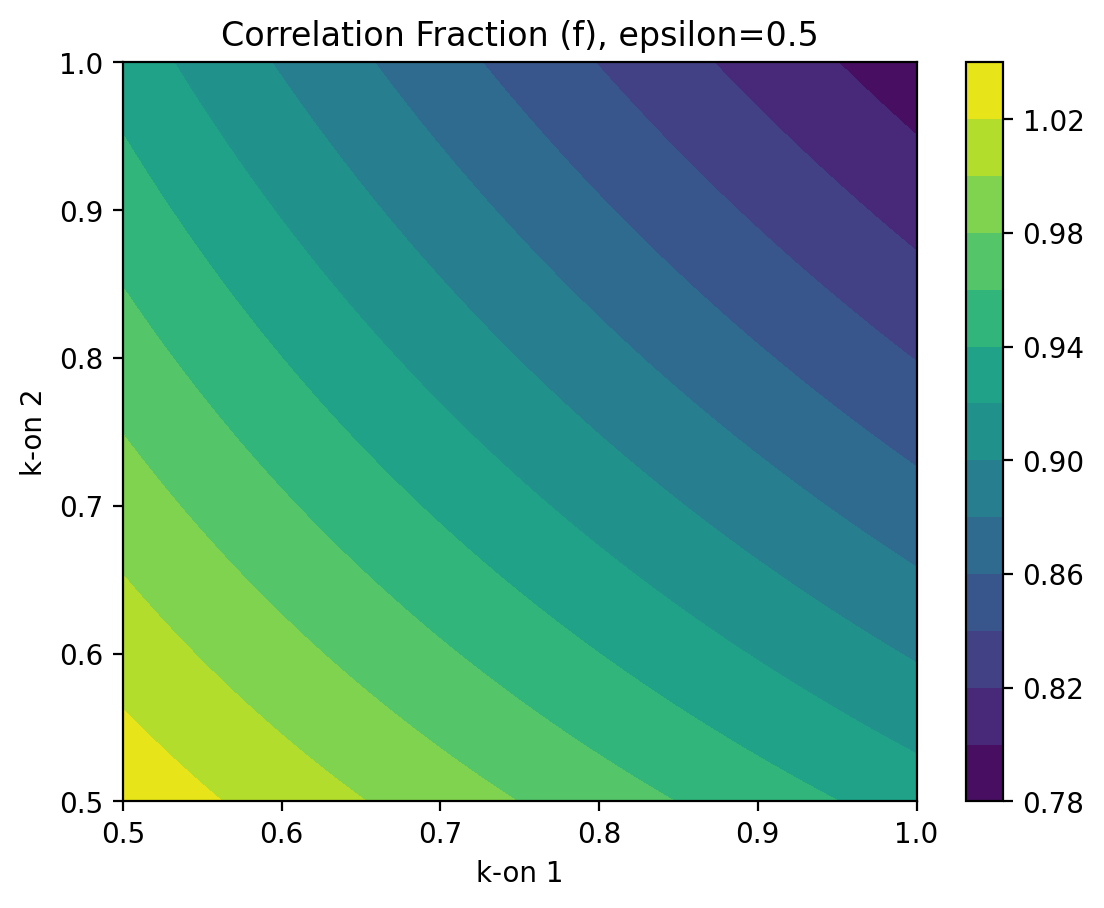

In [ ]:
# Calculate f for a range of values.

if __name__ == '__main__':

    # Left plot parameters.
    k_off, bs, ds, epsilon, sites = 30, [10,10], [1,1], 0.7, (0,1)

    contours_f(k_off, bs, ds, epsilon, sites)

    # Right plot parameters.
    k_off, bs, ds, epsilon, sites = 0.5, [10,10], [1,1], 0.5, (0,1)

    contours_f(k_off, bs, ds, epsilon, sites)
